In [1]:
# Package
from __future__ import print_function  
import torch     
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm
# from mpi4py import MPI
import time
import os 
import glob

from randomSearch import *
from mnist_utils import *

In [2]:
def get_best_acc(resultDict):
    best_acc = 0.0
    for hparams, acc in resultDict.items():
        if acc > best_acc:
            best_acc = acc
    return best_acc

In [3]:
MASTER_RANK = 0
mpiWorld = None
device = torch.device("cuda:1")

In [4]:
# REPRODUCIBILITY
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# === Init Search Space === #
lr = CRV(low=0.0, high=1.0, name="lr")
dr = CRV(low=0.0, high=1.0, name="dr")
mmt =CRV(low=0.0, high=1.0, name="mmt")
bs = DRV(choices=[16, 32, 64, 128, 256], name="bs")

hparams = HyperParams([lr, dr, mmt, bs])
randomSearch = RandomSearch(hparams)
print(randomSearch)

=== Random Search ===
lr:[0.0 ~ 1.0]
dr:[0.0 ~ 1.0]
mmt:[0.0 ~ 1.0]
bs:[16, 32, 64, 128, 256]



In [6]:
num_search = 400
pbars = {"search":tqdm(ncols=800, total=num_search, unit='search'), 
         "train":tqdm(ncols=1000), 
         "test":tqdm(ncols=1000)}
pbars['search'].set_description("Random Search")
resultDict = {}
for i in range(num_search):
    lr, dr, mmt, bs = randomSearch.get()
    acc = train_mnist(lr=lr, dr=dr,momentum=mmt, batch_size=bs, pbars=pbars)
    resultDict[(lr, dr, mmt, bs)] = acc
    pbars['search'].set_postfix({"Best":get_best_acc(resultDict)})
    pbars['search'].update()

KeyboardInterrupt: 

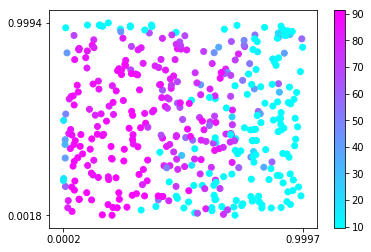

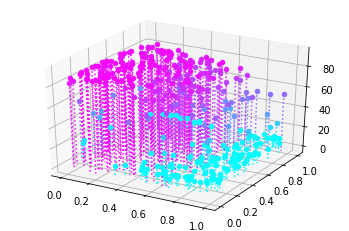

In [7]:
# hyperparams_list = []
# result_list = []
# for (lr, dr, mmt, bs), acc in resultDict.items():
#     hyperparams_list.append((lr, dr))
#     result_list.append(acc)
# vis_search(hyperparams_list, result_list)